# TextAnalysisProject Implementation Notebook

This notebook documents the steps that have been implemented so far in the **TextAnalysisProject**. It verifies:
1. Raw data files in S3.
2. Glue Data Catalog tables created by Crawlers.
3. The Glue ETL job for lexicon-based daily sentiment scoring.


## 1. Prerequisites

- AWS CLI must be configured with an IAM user or role that has access to the `TextDataProjectRole`.
- Required Python packages:
  ```bash
  pip install boto3 pyathena s3fs pandas
  ```
- The IAM role `TextDataProjectRole` should be able to access:
  - S3 buckets: `textdataproject-raw-snpnews-zitian`, `textdataproject-raw-lexicon-zitian`, `textdataproject-processed-features`, `textdataproject-query-results`
  - Glue Catalog and jobs
  - Athena queries


## 2. Download Data from Kaggle

Before uploading data to S3, we need to download the raw data from Kaggle. This section documents the process of downloading the required datasets.

In [ ]:
aws configure
pip3 install kaggle
mkdir -p ~/.kaggle
mv ~/Downloads/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

kaggle datasets download -d dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024
unzip s-and-p-500-with-financial-news-headlines-20082024.zip -d snp_news

kaggle datasets download -d dyutidasmahaptra/financial-sentiment-lexicon
unzip financial-sentiment-lexicon.zip -d lexicon

## 3. Upload Data to S3

After downloading the datasets, we need to upload them to their respective S3 buckets for further processing.

In [ ]:
aws s3 cp ./snp_news/ s3://textdataproject-raw-snpnews-zitian/ --recursive
aws s3 cp ./lexicon/ s3://textdataproject-raw-lexicon-zitian/ --recursive

## 4. Verify Raw Data in S3

We first check that the raw headline CSV (`sp500_headlines_2008_2024.csv`) and the lexicon CSV (`financial_sentiment_lexicon.csv`) are present in their respective buckets.


In [5]:
import boto3

s3 = boto3.client('s3')

# List objects in raw headlines bucket
print("Contents of textdataproject-raw-snpnews-zitian:")
resp1 = s3.list_objects_v2(Bucket="textdataproject-raw-snpnews-zitian", Prefix="")
for obj in resp1.get("Contents", []):
    print("-", obj["Key"])

# List objects in raw lexicon bucket
print("\nContents of textdataproject-raw-lexicon-zitian:")
resp2 = s3.list_objects_v2(Bucket="textdataproject-raw-lexicon-zitian", Prefix="")
for obj in resp2.get("Contents", []):
    print("-", obj["Key"])


Contents of textdataproject-raw-snpnews-zitian:
- sp500_headlines_2008_2024.csv

Contents of textdataproject-raw-lexicon-zitian:
- financial_sentiment_lexicon.csv


## 5. Verify Glue Data Catalog Tables

Glue Crawlers should have created:

- Database `snpnews_db` with table `sp500_headlines_2008_2024_csv`
- Database `lexicon_db` with table `financial_sentiment_lexicon_csv`

We use boto3 to list Glue databases and tables.


In [6]:
import boto3

glue = boto3.client('glue')

# List Glue databases
dbs = glue.get_databases()
print("Glue Databases:")
for db in dbs['DatabaseList']:
    print("-", db['Name'])

# List tables in snpnews_db
print("\nTables in snpnews_db:")
tables1 = glue.get_tables(DatabaseName="snpnews_db")
for t in tables1['TableList']:
    print("-", t['Name'])

# List tables in lexicon_db
print("\nTables in lexicon_db:")
tables2 = glue.get_tables(DatabaseName="lexicon_db")
for t in tables2['TableList']:
    print("-", t['Name'])


Glue Databases:
- lexicon_db
- snpnews_db

Tables in snpnews_db:
- sp500_headlines_2008_2024_csv

Tables in lexicon_db:
- financial_sentiment_lexicon_csv


## 6. Verify Glue ETL Job Output

The Glue ETL job `glue_job_news_sentiment_daily` should have written daily sentiment Parquet files to:
```
s3://textdataproject-processed-features/daily_sentiment_with_cp/
```
We list the contents of that prefix to confirm.


In [7]:
# List output files of Glue ETL job
resp3 = s3.list_objects_v2(
    Bucket="textdataproject-processed-features-zitian", 
    Prefix="daily_sentiment_with_cp/")
print("Contents of daily_sentiment_with_cp:")
for obj in resp3.get("Contents", []):
    print("-", obj["Key"])

resp4 = s3.list_objects_v2(
    Bucket="textdataproject-processed-features-zitian",
    Prefix="clean_headlines_for_finbert/"
)
print("Contents of clean_headlines_for_finbert:")
for obj in resp4.get("Contents", []):
    print("-", obj["Key"])


Contents of daily_sentiment_with_cp:
- daily_sentiment_with_cp/date=2008-01-02/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-01-03/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-01-07/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-01-09/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-01-10/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-01-22/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-01-29/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-01-30/part-00000-d0acb746-624d-4ede-b280-0e2172efda57.c000.snappy.parquet
- daily_sentiment_with_cp/date=2008-02-01/part-00000-d0acb746-624d-4ede-b280-0e2172

## 7. Verify Athena Table for Daily Sentiment

We check that the Athena table `sentiment_db.daily_sentiment_with_cp` exists and can return sample rows.


In [12]:
from pyathena import connect
import pandas as pd

conn = connect(
    s3_staging_dir='s3://textdataproject-query-results-zitian/', 
    region_name='eu-north-1'
)

# list all table in sentiment_db
print("Athena Tables in sentiment_db:")
tables = pd.read_sql("SHOW TABLES IN sentiment_db", conn)
print(tables)

print("\nSample rows from daily_sentiment_with_cp:")
sample_sentiment = pd.read_sql("""
    SELECT date, daily_total_score, daily_pos_count, daily_neg_count, daily_cp
    FROM sentiment_db.daily_sentiment_with_cp
    ORDER BY date
    LIMIT 5
""", conn)
print(sample_sentiment)

print("\nSample rows from clean_headlines_for_finbert:")
sample_headlines = pd.read_sql("""
    SELECT date, title_clean
    FROM sentiment_db.clean_headlines_for_finbert
    ORDER BY date
    LIMIT 5
""", conn)
print(sample_headlines)


Athena Tables in sentiment_db:


/var/folders/yp/cb8wz__516l5fbzrnmfzddlh0000gn/T/ipykernel_13907/143838419.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables = pd.read_sql("SHOW TABLES IN sentiment_db", conn)


                      tab_name
0  clean_headlines_for_finbert
1      daily_sentiment_with_cp

Sample rows from daily_sentiment_with_cp:


/var/folders/yp/cb8wz__516l5fbzrnmfzddlh0000gn/T/ipykernel_13907/143838419.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_sentiment = pd.read_sql("""


         date  daily_total_score  daily_pos_count  daily_neg_count  daily_cp
0  2008-01-02                0.0                0                0   1447.16
1  2008-01-03                0.0                0                0   1447.16
2  2008-01-07                0.0                0                0   1416.18
3  2008-01-09               -0.6                0                1   1409.13
4  2008-01-10                0.0                0                0   1420.33

Sample rows from clean_headlines_for_finbert:


/var/folders/yp/cb8wz__516l5fbzrnmfzddlh0000gn/T/ipykernel_13907/143838419.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_headlines = pd.read_sql("""


         date                                        title_clean
0  2008-01-02                        predictions for the s p    
1  2008-01-02  dow tallies biggest first session of year poin...
2  2008-01-02   jpmorgan predicts      will be  nothing but net 
3  2008-01-03  u s  stocks higher after economic data  monsan...
4  2008-01-07  u s  stocks climb as hopes increase for more f...


## 8. Run SageMaker Notebook for analysis.
In this section, we utilize Amazon SageMaker to perform sentiment analysis on financial news headlines using the FinBERT model. The notebook takes each headline from our dataset, passes it through the FinBERT model to predict sentiment scores (positive, neutral, negative), and integrates these sentiment scores back into our original dataset, enhancing our data with quantitative sentiment features for further analysis.

In [ ]:
import pandas as pd
from pyathena import connect

conn = connect(
    s3_staging_dir='s3://textdataproject-query-results-zitian/',
    region_name='eu-north-1'
)

query = """
SELECT date, title_clean
FROM sentiment_db.clean_headlines_for_finbert
"""
df_headlines = pd.read_sql(query, conn)

print("Total rows fetched:", len(df_headlines))
df_headlines.head(5)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import pandas as pd
from pyathena import connect

conn = connect(
    s3_staging_dir='s3://textdataproject-query-results-zitian/',
    region_name='eu-north-1'
)
query = """
SELECT date, title_clean
FROM sentiment_db.clean_headlines_for_finbert
"""
df_headlines = pd.read_sql(query, conn)
print(f"Total rows fetched: {len(df_headlines)}")

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ["negative", "neutral", "positive"]

def finbert_predict_with_progress(texts, batch_size=16):
    all_labels = []
    all_scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="FinBERT process"):
        batch = texts[i : i + batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**enc)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
        for p in probs:
            idx = p.argmax()
            all_labels.append(labels[idx])
            all_scores.append(float(p[idx]))
    return all_labels, all_scores

df_headlines["sentiment_label"], df_headlines["sentiment_score"] = finbert_predict_with_progress(
    df_headlines["title_clean"].tolist(),
    batch_size=16
)

df_headlines.head(5)


In [ ]:
import boto3
s3 = boto3.client("s3")
bucket = "textdataproject-processed-features-zitian"
prefix = "sentiment_per_headline"

for date, sub_df in df_headlines.groupby("date"):
    local_file = f"/tmp/sentiment_{date}.parquet"
    sub_df.to_parquet(local_file, index=False, engine="pyarrow")
    key = f"{prefix}/date={date}/sentiment.parquet"
    s3.upload_file(local_file, bucket, key)
    print(f"Uploaded date={date}  to  s3://{bucket}/{key}")

## 9. Analyze Parameter Correlations 
In this section, we explore the correlations between various parameters within our enriched dataset. By computing correlation matrices and visualizing these relationships, we aim to identify meaningful associations between sentiment scores, market indicators, and price movements. These insights can help clarify how sentiment signals influence or relate to market performance.



Correlation matrix:
                       avg_sent_diff  std_sentiment  daily_cp_from_lexicon  \
avg_sent_diff               1.000000      -0.866048              -0.052798   
std_sentiment              -0.866048       1.000000               0.165336   
daily_cp_from_lexicon      -0.052798       0.165336               1.000000   
next_return                 0.029062      -0.037855              -0.019120   

                       next_return  
avg_sent_diff             0.029062  
std_sentiment            -0.037855  
daily_cp_from_lexicon    -0.019120  
next_return               1.000000  


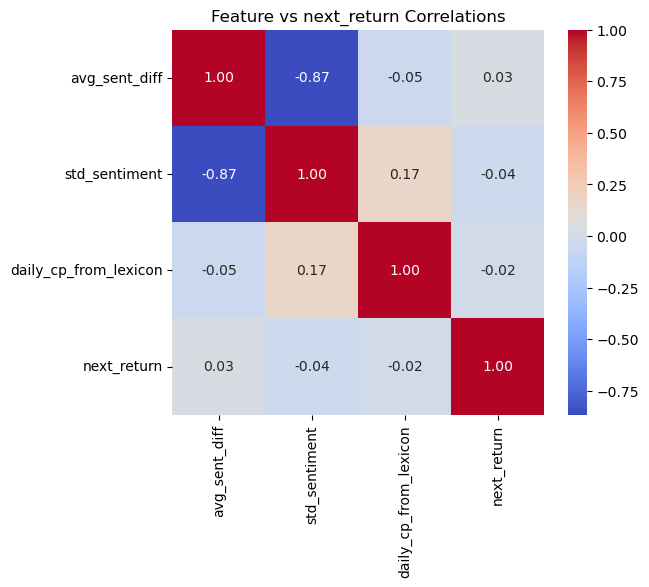

In [63]:
import io
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bucket = 'textdataproject-processed-features-zitian'
prefix = 'daily_features_v2/'
s3 = boto3.client('s3')

parts = []
paginator = s3.get_paginator('list_objects_v2')
for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
    for obj in page['Contents']:
        key = obj['Key']
        if key.endswith('/'):
            continue
        data = s3.get_object(Bucket=bucket, Key=key)['Body'].read()
        parts.append(pd.read_parquet(io.BytesIO(data)))

df = pd.concat(parts, ignore_index=True)

df = df.dropna(subset=["avg_sentiment", "std_sentiment", "daily_cp_from_lexicon", "next_return"])

df["std_sentiment"] = df["std_sentiment"].fillna(0)

global_avg = df["avg_sentiment"].mean()
df["avg_sent_diff"] = df["avg_sentiment"] - global_avg

cols = ["avg_sent_diff", "std_sentiment", "daily_cp_from_lexicon", "next_return"]
df_sub = df[cols]

corr_matrix = df_sub.corr()
print("Correlation matrix:")
print(corr_matrix)

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature vs next_return Correlations")
plt.show()


## 10. LightGBM Up/Down Classifier

This classifier uses a LightGBM model to predict whether the S&P 500 will go up or down the next day.  

- **Features:**  
  - `avg_sent_diff`: daily sentiment score minus global average  
  - `std_sentiment`: daily sentiment dispersion (filled with 0 if only one headline)  
  - `daily_cp_from_lexicon`: closing price from the merged dataset  

- **Label:**  
  - `label_up` = 1 if next day’s return > 0, else 0  

- **Training & Evaluation:**  
  - Data loaded from Parquet files on S3  
  - 5-fold TimeSeriesSplit (no time leakage)  
  - Early stopping with validation AUC  
  - Reported metrics per fold: AUC, accuracy, F1, and confusion matrix  

This simple non-linear model provides a baseline for text-driven market prediction.  


In [66]:
import io
import boto3
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

import lightgbm as lgb

# 1. Load Parquet parts from S3 into a single DataFrame
bucket = 'textdataproject-processed-features-zitian'
prefix = 'daily_features_v2/'
s3 = boto3.client('s3')

# Debug: list objects
keys = []
for page in s3.get_paginator('list_objects_v2').paginate(Bucket=bucket, Prefix=prefix):
    for obj in page['Contents']:
        keys.append(obj['Key'])
parts = []
for key in keys:
    if not key.endswith('/'):
        data = s3.get_object(Bucket=bucket, Key=key)['Body'].read()
        parts.append(pd.read_parquet(io.BytesIO(data)))
if not parts:
    raise RuntimeError("No parquet data found")
df = pd.concat(parts, ignore_index=True)

# 2. Cleaning & feature engineering
df = df.dropna(subset=["avg_sentiment", "std_sentiment", "daily_cp_from_lexicon", "next_return"])
df["std_sentiment"].fillna(0, inplace=True)
global_avg = df["avg_sentiment"].mean()
df["avg_sent_diff"] = df["avg_sentiment"] - global_avg
df["label_up"] = (df["next_return"] > 0).astype(int)

# 3. Prepare X, y
features = ["avg_sent_diff", "std_sentiment", "daily_cp_from_lexicon"]
X = df[features].values
y = df["label_up"].values

# 4. Standardize for linear models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 6. Define models
models = {
    "LogisticRegression": LogisticRegression(penalty="l2", solver="liblinear", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=42),
    "LightGBM": None
}

results = {}

# 7. Run experiments
for name, mdl in models.items():
    aucs, accs, f1s = [], [], []
    print(f"\n=== {name} ===")
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        # choose scaled or raw features
        if name == "LightGBM":
            X_tr, X_va = X[train_idx], X[val_idx]
        else:
            X_tr, X_va = X_scaled[train_idx], X_scaled[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]

        if name == "LightGBM":
            lgb_train = lgb.Dataset(X_tr, label=y_tr)
            lgb_val   = lgb.Dataset(X_va, label=y_va, reference=lgb_train)
            params = {
                "objective": "binary",
                "metric": "auc",
                "boosting_type": "gbdt",
                "learning_rate": 0.1,
                "num_leaves": 31,
                "verbose": -1,
                "seed": 42
            }
            booster = lgb.train(
                params,
                lgb_train,
                num_boost_round=200,
                valid_sets=[lgb_train, lgb_val],
                valid_names=["train", "valid"],
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
            )
            proba = booster.predict(X_va, num_iteration=booster.best_iteration)
            pred  = (proba > 0.5).astype(int)
        else:
            mdl.fit(X_tr, y_tr)
            proba = mdl.predict_proba(X_va)[:, 1]
            pred  = mdl.predict(X_va)

        auc = roc_auc_score(y_va, proba)
        acc = accuracy_score(y_va, pred)
        f1  = f1_score(y_va, pred)

        print(f"Fold {fold}: AUC={auc:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
        print("Confusion matrix:\n", confusion_matrix(y_va, pred))

        aucs.append(auc)
        accs.append(acc)
        f1s.append(f1)

    results[name] = {
        "Mean AUC": np.mean(aucs),
        "Mean Acc": np.mean(accs),
        "Mean F1": np.mean(f1s)
    }
    print(f"Mean AUC: {results[name]['Mean AUC']:.4f}, "
          f"Mean Acc: {results[name]['Mean Acc']:.4f}, "
          f"Mean F1: {results[name]['Mean F1']:.4f}")

# 8. Summary
print("\n=== Summary of All Models ===")
for name, metrics in results.items():
    print(f"{name}: AUC={metrics['Mean AUC']:.3f}, Acc={metrics['Mean Acc']:.3f}, F1={metrics['Mean F1']:.3f}")


/var/folders/yp/cb8wz__516l5fbzrnmfzddlh0000gn/T/ipykernel_38024/795704197.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["std_sentiment"].fillna(0, inplace=True)



=== LogisticRegression ===
Fold 1: AUC=0.5234, Acc=0.5061, F1=0.4163
Confusion matrix:
 [[163  50]
 [194  87]]
Fold 2: AUC=0.5044, Acc=0.5324, F1=0.6932
Confusion matrix:
 [[  2 230]
 [  1 261]]
Fold 3: AUC=0.5227, Acc=0.5344, F1=0.6806
Confusion matrix:
 [[ 19 199]
 [ 31 245]]
Fold 4: AUC=0.4892, Acc=0.5466, F1=0.7068
Confusion matrix:
 [[  0 224]
 [  0 270]]
Fold 5: AUC=0.5272, Acc=0.5061, F1=0.6720
Confusion matrix:
 [[  0 244]
 [  0 250]]
Mean AUC: 0.5134, Mean Acc: 0.5251, Mean F1: 0.6338

=== GradientBoosting ===
Fold 1: AUC=0.5461, Acc=0.4332, F1=0.0210
Confusion matrix:
 [[211   2]
 [278   3]]
Fold 2: AUC=0.4822, Acc=0.4595, F1=0.3718
Confusion matrix:
 [[148  84]
 [183  79]]
Fold 3: AUC=0.5381, Acc=0.5182, F1=0.5370
Confusion matrix:
 [[118 100]
 [138 138]]
Fold 4: AUC=0.4692, Acc=0.4615, F1=0.3785
Confusion matrix:
 [[147  77]
 [189  81]]
Fold 5: AUC=0.4721, Acc=0.4818, F1=0.5719
Confusion matrix:
 [[ 67 177]
 [ 79 171]]
Mean AUC: 0.5015, Mean Acc: 0.4709, Mean F1: 0.3760

=

/opt/miniconda3/envs/jyvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:07:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/jyvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:07:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/jyvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:07:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3: AUC=0.5559, Acc=0.5749, F1=0.6546
Confusion matrix:
 [[ 85 133]
 [ 77 199]]
Fold 4: AUC=0.5146, Acc=0.5243, F1=0.5913
Confusion matrix:
 [[ 89 135]
 [100 170]]
Fold 5: AUC=0.4404, Acc=0.4615, F1=0.4784
Confusion matrix:
 [[106 138]
 [128 122]]
Mean AUC: 0.5075, Mean Acc: 0.5049, Mean F1: 0.4994

=== LightGBM ===
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.805022	valid's auc: 0.540583
Fold 1: AUC=0.5406, Acc=0.5020, F1=0.5138
Confusion matrix:
 [[118  95]
 [151 130]]


/opt/miniconda3/envs/jyvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:07:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/jyvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:07:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.764179	valid's auc: 0.491182
Fold 2: AUC=0.4912, Acc=0.4717, F1=0.3650
Confusion matrix:
 [[158  74]
 [187  75]]
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.786766	valid's auc: 0.556193
Fold 3: AUC=0.5562, Acc=0.5547, F1=0.6382
Confusion matrix:
 [[ 80 138]
 [ 82 194]]
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	train's auc: 0.897927	valid's auc: 0.551224
Fold 4: AUC=0.5512, Acc=0.5263, F1=0.6366
Confusion matrix:
 [[ 55 169]
 [ 65 205]]
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.689979	valid's auc: 0.471197
Fold 5: AUC=0.4712, Acc=0.5061, F1=0.6720
Confusion matrix:
 [[  0 244]
 [  0 250]]
Mean AUC: 0.5221, Mean Acc: 0.5121, Mean F1: 0.5651

=== Summary of All Models ===
Log